In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Install packages (run only once in the runtime)

In [1]:
!pip install deepxde

     |████████████████████████████████| 123 kB 5.1 MB/s 
     |████████████████████████████████| 100 kB 3.3 MB/s 


Imports and functions

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


# get training data
def gen_traindata():
    response = requests.get('https://github.com/lululxvi/deepxde/raw/master/examples/dataset/Lorenz.npz')
    response.raise_for_status()
    data = np.load(io.BytesIO(response.content))
    return data["t"], data["y"]

# parameters to be identified
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8/3

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

def boundary(_, on_initial):
    return on_initial

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



Define data and BCs

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  total_n_samples))


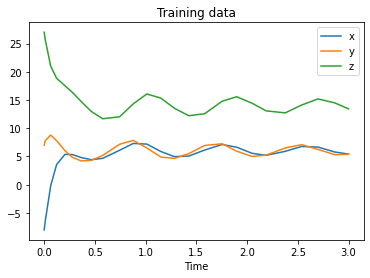

In [3]:
# define time domain
geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 27, boundary, component=2)

# Get the training data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

# define data object
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

plt.plot(observe_t, ob_y)
plt.xlabel('Time')
plt.legend(['x','y','z'])
plt.title('Training data')
plt.show()


# ResNet Network

In [4]:
# define FNN architecture and compile
resnet = dde.maps.ResNet(input_size=1,
                      output_size=3,
                      activation="tanh",
                      kernel_initializer="Glorot uniform",
                      num_blocks=3,
                      num_neurons=64
                      )
res_model = dde.Model(data, resnet)
res_model.compile("adam", lr=0.001)

Compiling model...
Building residual neural network...


/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/resnet.py:70: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_regularizer=self.regularizer,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'build' took 0.252632 s

'compile' took 6.663527 s



In [5]:
res_model.print_model()

FailedPreconditionError: ignored

In [6]:

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = res_model.train(epochs=60000, callbacks=[variable])

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.47e-01, 3.34e-01, 8.77e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.27e+01, 3.51e+01, 2.42e+02]    [1.47e-01, 3.34e-01, 8.77e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.27e+01, 3.51e+01, 2.42e+02]    []  
1000      [9.39e+00, 1.92e+00, 2.50e+00, 1.48e+01, 3.77e-01, 7.99e-01, 3.15e+01, 1.80e+01, 6.32e+00]    [9.39e+00, 1.92e+00, 2.50e+00, 1.48e+01, 3.77e-01, 7.99e-01, 3.15e+01, 1.80e+01, 6.32e+00]    []  
2000      [8.84e+00, 1.75e+00, 1.17e+00, 1.33e+01, 3.94e-01, 1.48e+00, 3.24e+01, 1.93e+01, 3.16e+00]    [8.84e+00, 1.75e+00, 1.17e+00, 1.33e+01, 3.94e-01, 1.48e+00, 3.24e+01, 1.93e+01, 3.16e+00]    []  
3000      [8.42e+00, 1.92e+00, 9.57e-01, 1.28e+01, 3.12e-01, 1.57e+00, 3.26e+01, 1.91e+01, 2.72e+00]    [8.42e+00, 1.92e+00, 9.57e-01, 1

In [7]:
# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8/3

y_true = [C1true, C2true, C3true]
y_pred = res_model.predict(observe_t)

In [8]:
y_pred.shape

(25, 3)

In [9]:
y_pred = res_model.predict(observe_t)
dde.metrics.l2_relative_error(ob_y, y_pred)

0.000865393169927097

 Plot identified parameters

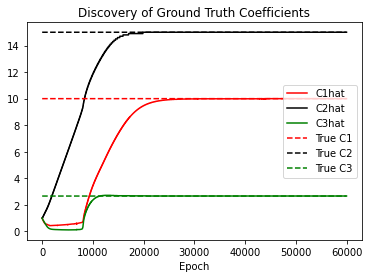

In [10]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.title('Discovery of Ground Truth Coefficients')
plt.show()

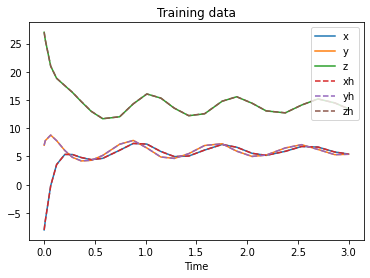

In [11]:
yhat = res_model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()

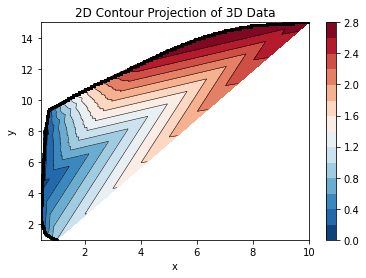

In [12]:
'''
Source:
https://github.com/lululxvi/deepxde/issues/276
'''
#data = np.genfromtxt(fnamevar, delimiter=' ')
x = Chat[:,0]
y = Chat[:,1]
z = Chat[:,2]

fig, ax = plt.subplots(nrows=1)
ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr, ax=ax)
ax.plot(x, y, 'k.', ms=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('2D Contour Projection of 3D Data')
plt.show()

In [13]:
C1true, C2true, C3true

(10, 15, 2.6666666666666665)

Text(0.5, 0.92, '3D Scatterplot')

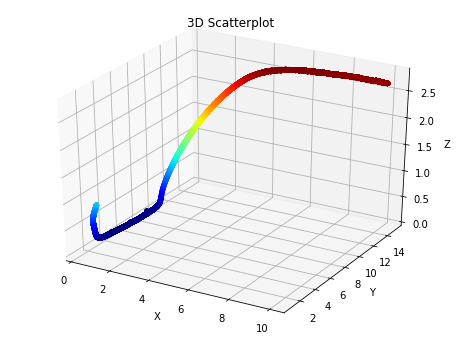

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z, cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Scatterplot')

# Hyperparameter Tuning

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%matplotlib inline

In [ ]:
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import CSVLogger
import datetime
tf.disable_v2_behavior()

In [ ]:
'''
Source:
https://stackoverflow.com/questions/42481938/attributeerror-module-object-has-no-attribute-merge-all-summaries
'''
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter

In [ ]:
'''
Source:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams
'''
HP_NUM_BLOCKS = hp.HParam('num_blocks', hp.Discrete([3, 5, 7]))
HP_NUM_NEURONS = hp.HParam('num_neurons', hp.Discrete([32, 64, 128]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.002]))
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_EPOCH = hp.HParam('epoch', hp.Discrete([10000, 30000, 50000]))

METRIC_LOSS = 'loss'


#writer = tf.summary.create_file_writer('logs/hparam_tuning')
writer = tf.summary.FileWriter('logs/hparam_tuning')
#writer = tf.train.SummaryWriter('logs/hparam_tuning')
with writer:
  hp.hparams_config(
    hparams=[HP_NUM_BLOCKS, HP_NUM_NEURONS, HP_LEARNING_RATE, HP_EPOCH],
    metrics=[hp.Metric(METRIC_LOSS, display_name='loss')],
  )

In [ ]:
def make_model(hparams):
  # define FNN architecture and compile
  net = dde.maps.ResNet(input_size=1,
                        output_size=3,
                        activation="tanh",
                        kernel_initializer="Glorot uniform",
                        num_blocks=hparams[HP_NUM_BLOCKS],
                        num_neurons=hparams[HP_NUM_NEURONS]
                        )
  model = dde.Model(data, net)
  #model.compile(hparams[OPTIMIZER], lr=hparams[HP_OPTIMIZER])
  return model

In [ ]:
def make_coef_plot(session_num, fnamevar):
  # reopen saved data using callbacks in fnamevar 
  lines = open(fnamevar, "r").readlines()

  # read output data in fnamevar (this line is a long story...)
  Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

  l,c = Chat.shape

  # Coefficient plot
  fig_filename = '/content/drive/My Drive/deeplearning_finalproject/coefficient_plot_session_{num}.png'.format(num=session_num)

  plt.plot(range(l),Chat[:,0],'r-')
  plt.plot(range(l),Chat[:,1],'k-')
  plt.plot(range(l),Chat[:,2],'g-')
  plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
  plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
  plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
  plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
  plt.xlabel('Epoch')
  plt.title('Discovery of Ground Truth Coefficients')
  plt.savefig(fig_filename)
  plt.clf()

In [ ]:
def make_preds_plot(session_num, model):
  # Prediction plot
  preds_fig_filename = '/content/drive/My Drive/deeplearning_finalproject/prediction_plot_session_{num}.png'.format(num=session_num)
  yhat = model.predict(observe_t)

  plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
  plt.xlabel('Time')
  plt.legend(['x','y','z','xh','yh','zh'])
  plt.title('Ground Truth vs Prediction')
  plt.savefig(preds_fig_filename)
  plt.clf()

In [ ]:
def make_contour_plot(session_num, fnamevar, model):
  # reopen saved data using callbacks in fnamevar 
  lines = open(fnamevar, "r").readlines()

  # read output data in fnamevar (this line is a long story...)
  Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

  l,c = Chat.shape

  # Coefficient plot
  fig_filename = '/content/drive/My Drive/deeplearning_finalproject/contour_plot_session_{num}.png'.format(num=session_num)
  
  '''
  Source:
  https://github.com/lululxvi/deepxde/issues/276
  '''
  #data = np.genfromtxt(fnamevar, delimiter=' ')
  x = Chat[:,0]
  y = Chat[:,1]
  z = Chat[:,2]

  fig, ax = plt.subplots(nrows=1)
  ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
  cntr = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

  fig.colorbar(cntr, ax=ax)
  ax.plot(x, y, 'k.', ms=3)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.title('2D Contour Projection of 3D Data')
  plt.savefig(fig_filename)
  plt.clf()

In [ ]:
def make_3d_scatter(session_num, fnamevar, model):
  fig_filename = '/content/drive/My Drive/deeplearning_finalproject/3d_scatter_plot_session_{num}.png'.format(num=session_num)
  
  # reopen saved data using callbacks in fnamevar 
  lines = open(fnamevar, "r").readlines()

  # read output data in fnamevar (this line is a long story...)
  Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

  l,c = Chat.shape
  
  x = Chat[:,0]
  y = Chat[:,1]
  z = Chat[:,2]

  fig = plt.figure(figsize=(8, 6))
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, c=z, cmap='jet')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  plt.title('3D Scatterplot')
  plt.savefig(fig_filename)
  plt.clf()

In [ ]:
'''
Source:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams
'''
def train_test_model(hparams, session_num):
  model = make_model(hparams)
  model.compile('adam',
                lr=hparams[HP_LEARNING_RATE])

  # callbacks for storing results
  fnamevar = '/content/drive/My Drive/deeplearning_finalproject/variables_session_{num}.dat'.format(num=session_num)
  variable = dde.callbacks.VariableValue(
      [C1, C2, C3], 
      period=1,
      filename=fnamevar
  )

  losshistory, train_state = model.train(epochs=hparams[HP_EPOCH], callbacks=[variable])

  # Calculate L2 Relative Error
  # Needs to be done manually since the metric option when compiling doesn't work
  y_pred = model.predict(observe_t)
  l2_relative_error = dde.metrics.l2_relative_error(ob_y, y_pred)

  # Make the plots corresponding to this model
  make_coef_plot(session_num, fnamevar)
  make_preds_plot(session_num, model)
  make_contour_plot(session_num, fnamevar, model)
  make_3d_scatter(session_num, fnamevar, model)

  return losshistory, l2_relative_error

In [ ]:
model_scores = []

In [ ]:
'''
Source:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams
'''
def run(run_dir, hparams, session_num):
  with tf.summary.FileWriter(run_dir):
  #with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    loss, l2_relative_error = train_test_model(hparams, session_num)
    
    #print('###################')
    #print('loss.loss_test: ', loss.loss_test)
    #print('###################')
    #print('')
    
    losses = loss.loss_test[0][0:3]
    average_test_loss = np.mean(losses)
    #accuracy = loss.metrics_test
    
    print('###################')
    print('X, Y, Z Losses:    ', losses)
    print('Average Test Loss: ', average_test_loss)
    print('###################')
    print('')
    print('###################')
    print('L2 Relative Error: ', l2_relative_error)
    print('')
    #print('Accuracy :', accuracy)

    temp_dict = {h.name: hparams[h] for h in hparams}
    temp_dict['average_loss'] = average_test_loss
    temp_dict['x_loss'] = losses[0]
    temp_dict['y_loss'] = losses[1]
    temp_dict['z_loss'] = losses[2]
    temp_dict['l2_relative_error'] = l2_relative_error
    #temp_dict['accuracy'] = accuracy

    model_scores.append(temp_dict)
    tf.summary.scalar(METRIC_LOSS, average_test_loss)

In [ ]:
'''
Source:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams
'''
session_num = 0
for num_blocks in HP_NUM_BLOCKS.domain.values:
  for num_neurons in HP_NUM_NEURONS.domain.values:
    for learning_rate in HP_LEARNING_RATE.domain.values:
      for epoch in HP_EPOCH.domain.values:
        hparams = {
           HP_NUM_BLOCKS: num_blocks,
           HP_NUM_NEURONS: num_neurons,
           HP_LEARNING_RATE: learning_rate,
           HP_EPOCH: epoch
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams, session_num)
        session_num += 1

In [ ]:
print(model_scores)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_dict(model_scores)
df.to_csv('/content/drive/My Drive/deeplearning_finalproject/model_scores.csv', columns=df.columns)

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!ls

In [ ]:
!ls logs/hparam_tuning/

# Plot Results

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/deeplearning_finalproject/model_scores.csv')

In [ ]:
df.columns

In [ ]:
df.rename(columns={'Unnamed: 0':'session'}, inplace=True)

In [ ]:
df.head()

In [ ]:
df = df.sort_values(by=['l2_relative_error', 'average_loss'], ascending=[True, True])

In [ ]:
df.head()

In [ ]:
df.to_csv('/content/drive/My Drive/deeplearning_finalproject/sorted_model_scores.csv', columns=df.columns)

In [ ]:
df.dtypes

In [ ]:
df['accuracy'][0]

In [ ]:
df['accuracy'] = [str(i.replace('[','')) for i in df['accuracy']]
df['accuracy'] = [str(i.replace(']','')) for i in df['accuracy']]

In [ ]:
df['accuracy'] = pd.to_numeric(df['accuracy'], errors='coerce')

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

In [ ]:
splot = sns.violinplot(data=df, x="num_blocks", y="average_loss", hue="learning_rate",
               split=True, inner="quart", linewidth=1,
               palette={0.001: "b", 0.002: "g"})
sns.despine(left=True)
plt.xlabel('Number of ResNet Blocks')
plt.ylabel('Average Loss of Coefficients')
plt.title('Average Loss by Number of Blocks per Learning Rate')

In [ ]:
splot = sns.violinplot(data=df, x="num_neurons", y="average_loss", hue="learning_rate",
               split=True, inner="quart", linewidth=1,
               palette={0.001: "b", 0.002: "g"})
sns.despine(left=True)
plt.xlabel('Neural Density')
plt.ylabel('Average Loss of Coefficients')
plt.title('Average Loss by Neural Density per Learning Rate')

In [ ]:
splot = sns.violinplot(data=df, x="epoch", y="average_loss", hue="learning_rate",
               split=True, inner="quart", linewidth=1,
               palette={0.001: "b", 0.002: "g"})
sns.despine(left=True)
plt.xlabel('Epochs')
plt.ylabel('Average Loss of Coefficients')
plt.title('Average Loss by Epoch per Learning Rate')

In [ ]:
splot = sns.violinplot(data=df, x="num_blocks", y="l2_relative_error", hue="learning_rate",
               split=True, inner="quart", linewidth=1,
               palette={0.001: "r", 0.002: "b"})
sns.despine(left=True)
plt.xlabel('Number of ResNet Blocks')
plt.ylabel('L2 Relative Error')
plt.title('L2 Relative Error by Number of Blocks per Learning Rate')

In [ ]:
splot = sns.violinplot(data=df, x="num_neurons", y="l2_relative_error", hue="learning_rate",
               split=True, inner="quart", linewidth=1,
               palette={0.001: "r", 0.002: "b"})
sns.despine(left=True)
plt.xlabel('Neural Density')
plt.ylabel('L2 Relative Error')
plt.title('L2 Relative Error by Neural Density per Learning Rate')

In [ ]:
splot = sns.violinplot(data=df, x="epoch", y="l2_relative_error", hue="learning_rate",
               split=True, inner="quart", linewidth=1,
               palette={0.001: "r", 0.002: "b"})
sns.despine(left=True)
plt.xlabel('Epochs')
plt.ylabel('L2 Relative Error')
plt.title('L2 Relative Error by Epoch per Learning Rate')

In [ ]:
fnamevar = '/content/drive/My Drive/deeplearning_finalproject/variables_session_20.dat'
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
#plt.show()
plt.savefig('/content/drive/My Drive/deeplearning_finalproject/testfig.png')

In [ ]:
yhat = res_model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()